In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import gzip
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [ ]:
# Load the dataset
file_path = '/content/drive/MyDrive/cmpe256_hotel_recommendation_system/data/processed/hotelrec_2013_2017_cleaned.csv.gz'

with gzip.open(file_path, 'rt') as f:
    df = pd.read_csv(f)

In [ ]:
label_encoder_author = LabelEncoder()
df['author_id'] = label_encoder_author.fit_transform(df['author'])
label_encoder_hotel = LabelEncoder()
df['hotel_id'] = label_encoder_hotel.fit_transform(df['hotel_id'])

## NeuMF

In [ ]:
# Define inputs and target
X = df[['hotel_id', 'author_id']]
y = df['rating']

In [ ]:
# First split: 70% train, 30% temporary (validation + test)
# Train-validation split

# First split: 70% train, 30% temporary (validation + test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Second split: 50% validation, 50% test (from the 30% temporary set)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

In [ ]:
class HotelDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.values, dtype=torch.int64)  # Convert to tensor directly
        self.y = torch.tensor(y.values, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [ ]:
# DataLoaders
train_ds = HotelDataset(X_train, y_train)
val_ds = HotelDataset(X_val, y_val)
test_ds = HotelDataset(X_test, y_test)

train_dl = DataLoader(train_ds, batch_size=8000, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=8000)
test_dl = DataLoader(test_ds, batch_size=8000)

In [ ]:
n_hotels = len(label_encoder_hotel.classes_)
n_authors = len(label_encoder_author.classes_)


In [ ]:
class HotelNeuMF(nn.Module):
    def __init__(self, n_hotels, n_authors, embed_size=32):
        super().__init__()

        # Adding one extra embedding for the "unknown" token
        self.hotel_emb = nn.Embedding(n_hotels + 1, embed_size)  # +1 for "unknown" token
        self.author_emb = nn.Embedding(n_authors + 1, embed_size)  # +1 for "unknown" token

        # GMF block - classic matrix factorization (element-wise product)
        self.gmf = nn.Sequential(
            nn.Linear(embed_size, 1)  # After element-wise product, we reduce the output to a single scalar
        )

        # MLP block
        self.mlp = nn.Sequential(
            nn.Linear(embed_size * 2, 64),  # Removing service and sentiment_score, hence only embedding sizes
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

        # Final fusion layer
        self.final = nn.Sequential(
            nn.Linear(2, 1)
        )

    def forward(self, hotel_ids, author_ids):
        # Handle unseen IDs (map to "unknown" token, i.e., index 0)
        hotel_ids = torch.where(hotel_ids >= self.hotel_emb.num_embeddings,
                                 torch.tensor(0, device=hotel_ids.device), hotel_ids)
        author_ids = torch.where(author_ids >= self.author_emb.num_embeddings,
                                  torch.tensor(0, device=author_ids.device), author_ids)

        # Get embeddings for hotels and authors
        hotel_emb = self.hotel_emb(hotel_ids)
        author_emb = self.author_emb(author_ids)

        # Element-wise product for GMF
        gmf_vector = hotel_emb * author_emb  # Element-wise multiplication

        # Apply GMF block (this is just a linear transformation now)
        gmf_out = self.gmf(gmf_vector)

        # Prepare input for MLP (only embeddings)
        emb_cat = torch.cat([hotel_emb, author_emb], dim=1)
        mlp_out = self.mlp(emb_cat)

        # Combine the GMF and MLP outputs
        combined = torch.cat([gmf_out, mlp_out], dim=1)

        # Final prediction layer
        rating = self.final(combined)

        return rating.squeeze()  # Remove any extra dimensions

In [ ]:
# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HotelNeuMF(
    n_hotels=n_hotels,
    n_authors=n_authors,
).to(device)

In [ ]:
from torch.optim.lr_scheduler import OneCycleLR

loss_fn = nn.MSELoss()
# Optimizer (start with a lower base LR)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Scheduler with warmup + decay
scheduler = OneCycleLR(optimizer,
                       max_lr=1e-2,             # peak LR
                       steps_per_epoch=len(train_dl),
                       epochs=3,
                       pct_start=0.3,           # warmup for 30% of total steps
                       anneal_strategy='cos',   # cosine annealing
                       div_factor=8.0,          # start LR = max_lr / div_factor
                       final_div_factor=1e4)    # how small the final LR should be

In [ ]:
from tqdm import tqdm

# Training Loop
train_losses = []
val_losses = []
epochs = 12
best_val_loss = float('inf')  # Start with the worst possible loss

import time

start_time = time.time()

for epoch in range(epochs):
    epoch_start_time = time.time()  # Time at the beginning of the epoch
    model.train()
    train_loss = 0.0
    train_loop = tqdm(train_dl, leave=False) # wrap train_dl with tqdm
    for X, y in train_loop:
        optimizer.zero_grad()
        preds = model(X[:, 0].to(device), X[:, 1].to(device))
        loss = loss_fn(preds.squeeze(), y.to(device))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_loop.set_description(f"Epoch [{epoch+1}/{epochs}]")
        train_loop.set_postfix(loss=loss.item()) # add loss to progress bar

    avg_train_loss = train_loss / len(train_dl)
    train_losses.append(avg_train_loss)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X, y in val_dl:
            preds = model(X[:, 0].to(device), X[:, 1].to(device))
            loss = loss_fn(preds.squeeze(), y.to(device))
            val_loss += loss.item()

    scheduler.step()

    avg_val_loss = val_loss / len(val_dl)
    val_losses.append(avg_val_loss)

    epoch_end_time = time.time() # Time at the end of the epoch
    epoch_time = epoch_end_time - epoch_start_time
    remaining_time = (epochs - (epoch+1)) * epoch_time  # Estimated remaining time

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Epoch Time: {epoch_time:.2f}s, Est. Remaining Time: {remaining_time:.2f}s")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), '/content/drive/MyDrive/cmpe256_hotel_recommendation_system/models/neumf_model.pt')
        print(f"✅ Model saved at epoch {epoch+1} with Val Loss: {avg_val_loss:.4f}")

end_time = time.time()
total_training_time = end_time - start_time
print(f"Total training time: {total_training_time:.2f} seconds")


Epoch 1/12, Train Loss: 1.4590, Val Loss: 0.9844, Epoch Time: 919.46s, Est. Remaining Time: 10114.04s
✅ Model saved at epoch 1 with Val Loss: 0.9844


Epoch 2/12, Train Loss: 0.9441, Val Loss: 0.9546, Epoch Time: 917.83s, Est. Remaining Time: 9178.25s
✅ Model saved at epoch 2 with Val Loss: 0.9546


Epoch 3/12, Train Loss: 0.8855, Val Loss: 0.9600, Epoch Time: 914.59s, Est. Remaining Time: 8231.34s


Epoch 4/12, Train Loss: 0.8004, Val Loss: 0.9927, Epoch Time: 913.81s, Est. Remaining Time: 7310.51s


Epoch 5/12, Train Loss: 0.6959, Val Loss: 1.0448, Epoch Time: 917.67s, Est. Remaining Time: 6423.66s


Epoch 6/12, Train Loss: 0.5826, Val Loss: 1.1083, Epoch Time: 914.39s, Est. Remaining Time: 5486.32s


Epoch 7/12, Train Loss: 0.4772, Val Loss: 1.1776, Epoch Time: 913.90s, Est. Remaining Time: 4569.52s


Epoch 8/12, Train Loss: 0.3893, Val Loss: 1.2458, Epoch Time: 912.85s, Est. Remaining Time: 3651.38s


Epoch 9/12, Train Loss: 0.3189, Val Loss: 1.3299, Epoch Time: 911.56s, Est. Remaining Time: 2734.68s


Epoch 10/12, Train Loss: 0.2636, Val Loss: 1.3926, Epoch Time: 911.20s, Est. Remaining Time: 1822.41s


Epoch 11/12, Train Loss: 0.2211, Val Loss: 1.4351, Epoch Time: 915.21s, Est. Remaining Time: 915.21s


Epoch 12/12, Train Loss: 0.1890, Val Loss: 1.4973, Epoch Time: 914.26s, Est. Remaining Time: 0.00s
Total training time: 10990.11 seconds


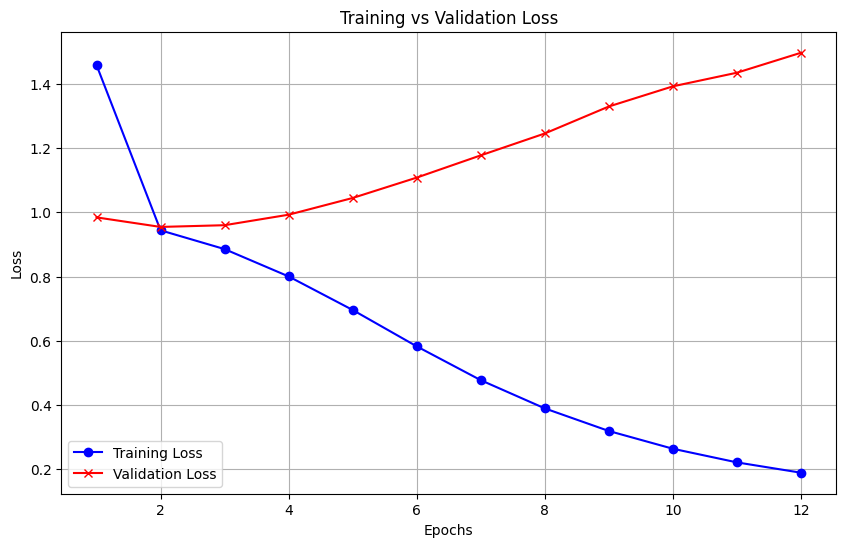

In [ ]:
import matplotlib.pyplot as plt

# Plotting the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, label="Training Loss", color='blue', linestyle='-', marker='o')
plt.plot(range(1, epochs + 1), val_losses, label="Validation Loss", color='red', linestyle='-', marker='x')

# Add labels and title
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Show the plot
plt.grid(True)
plt.show()


In [ ]:
# model.load_state_dict(torch.load('/content/drive/MyDrive/cmpe256_hotel_recommendation_system/models/neumf_model.pt'))
# model.to(device)

# Switch to evaluation mode
model.eval()

# Initialize variables to track loss and accuracy
test_loss = 0.0
predictions = []
true_values = []

with torch.no_grad():  # Disable gradient calculation for evaluation
    for X, y in test_dl:  # Or use `test_dl` if testing set
        X, y = X.to(device), y.to(device)

        # Unpack features
        hotel_ids, author_ids = X[:, 0], X[:, 1]

        # Get predictions from the model
        preds = model(hotel_ids, author_ids).squeeze()

        # Calculate loss
        loss = loss_fn(preds, y)
        test_loss += loss.item()

        # Collect predictions and true values for evaluation
        predictions.extend(preds.cpu().numpy())  # Move to CPU for storage
        true_values.extend(y.cpu().numpy())

# Calculate average test loss
avg_test_loss = test_loss / len(test_dl)
print(f"Test Loss: {avg_test_loss:.4f}")

# Optionally, calculate RMSE or other metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

rmse = np.sqrt(mean_squared_error(true_values, predictions))
print(f"RMSE: {rmse:.4f}")
mae = mean_absolute_error(true_values, predictions)
print(f"MAE: {mae:.4f}")


Test Loss: 0.4085
RMSE: 0.6392
MAE: 0.4576
